<h1 style="color: 	#80B1D3;"><strong>QUBIT ERROR PREDICTION</strong></h1>


<h2 style="color: 	#365F93;"><strong>Overview</strong></h2>

**Author:** Xavi

**Date:** June 2025 

**Environment:** Jupyter Notebook · Python 

---

<h3 style="color: 	#365F93;">🎯 Objective</h3>

This project aims to develop a machine learning model capable of **predicting the readout assignment error of a physical qubit** based on its calibration parameters and quantum hardware conditions.  
The model is trained on real data from **IBM QPUs**, starting with the `ibm_sherbrooke` processor and later extended to others for generalization and transfer learning analysis.

Throughout the project, we will explore and compare multiple regression algorithms **(e.g., KNN, linear regression, decision trees, etc.)** to evaluate which model best predicts the assignment error based on performance metrics like MAE and R².

---

<h3 style="color: 	#365F93;">📦 Steps Covered in This Notebook</h3>

1. **Data Acquisition** from IBM Quantum dashboard  
2. **Data Cleaning & Preprocessing**  
3. **Exploratory Data Analysis (EDA)**  
4. **Feature Engineering**  
5. **First Baseline Model**
6. **Other Models**
7. **Conclusions**

---

<h3 style="color: 	#365F93;">📁 Dataset</h3>

- Source: IBM Quantum backend calibration data (`ibm_sherbrooke`)
- Format: `.csv`
- Records: ~127 qubits
- Target Variable:  
  - `Readout assignment error` 

- Feature Variables (examples):  
  - `T1 (us)`, `T2 (us)`, `Frequency (GHz)`, `Anharmonicity (GHz)`, `Readout length (ns)`

---

<h2 style="color: 	#365F93;"><strong>Libraries/Functions/API</strong></h2>

In [ ]:
# Run in the terminal: pip install -r requirements.txt

In [ ]:
# Install required packages if not already installed
!pip install pandas --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install scikit-learn --quiet
!pip install xgboost --quiet
!pip install shap --quiet
!pip install qiskit==0.45.1 --quiet
!pip install qiskit-ibm-provider==0.8.0 --quiet
!pip install python-dotenv --quiet
!pip install qiskit-ibmq-provider --quiet

In [ ]:
# Importing necessary libraries for data preprocessing, model training, and evaluation

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [2]:
# Importing custom utility functions from the src/functions.py script

import os
import sys
sys.path.append('../src')
from functions import *

In [3]:
from qiskit_ibm_provider import IBMProvider
from dotenv import load_dotenv

load_dotenv('../ibm_quantum_key.env')

ibm_token = os.getenv("IBM_QUANTUM_TOKEN")

provider = IBMProvider(token=ibm_token)
provider.backends()

[<IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_brisbane')>]

<h2 style="color: 	#365F93;"><strong>1. Data Collection</strong></h2>

In [4]:
''''
This code is to extract all the data from the API, but it is not necessary to run it, we can upload the dataset from the raw folder inside the data folder

df_sherbrooke = load_calibration_history(
    token=ibm_token,
    backend_name="ibm_sherbrooke",
    start_date="2024-01-01",
    end_date="2025-06-01",
    step_days=1
)

'''

'\'\nThis code is to extract all the data from the API, but it is not necessary to run it, we can upload the dataset from the raw folder inside the data folder\n\ndf_sherbrooke = load_calibration_history(\n    token=ibm_token,\n    backend_name="ibm_sherbrooke",\n    start_date="2024-01-01",\n    end_date="2025-06-01",\n    step_days=1\n)\n\n'

In [5]:
# To save what has been downloaded from the API in the raw folder inside the data folder
#df_sherbrooke.to_csv('../data/raw/df_sherbrooke.csv', index=False)

In [4]:
# To upload the dataset
df_sherbrooke = pd.read_csv('../data/raw/df_sherbrooke.csv')

In [5]:
data_overview(df_sherbrooke)

DataFrame Head
         date  qubit     T1 (us)   T2 (us)  Frequency (GHz)  \
0  2024-01-01      0  214.317737  4.635668       362.553985   
1  2024-01-01      1  250.813950  4.736282       325.227421   
2  2024-01-01      2  156.053953  4.819172       210.204496   
3  2024-01-01      3  164.308282  4.747176       357.164540   
4  2024-01-01      4  245.261393  4.787861       393.719263   

   Anharmonicity (GHz)  Readout assignment error  Prob meas0 prep1  \
0            -0.313276                    0.0040            0.0054   
1            -0.312918                    0.0077            0.0102   
2            -0.311295                    0.0355            0.0262   
3            -0.311153                    0.0054            0.0074   
4            -0.310945                    0.0093            0.0134   

   Prob meas1 prep0  Readout length (ns)  ID error  \
0            0.0026          1244.444444  0.000092   
1            0.0052          1244.444444  0.000339   
2            0.0448    

In [6]:
df_sherbrooke

,date,qubit,T1 (us),T2 (us),Frequency (GHz),Anharmonicity (GHz),Readout assignment error,Prob meas0 prep1,Prob meas1 prep0,Readout length (ns),ID error,Z-axis rotation (rz) error,√x (sx) error,Pauli-X error,ECR error,Gate time (ns),Operational
0,2024-01-01,0,214.317737,4.635668,362.553985,-0.313276,0.004000,0.005400,0.002600,1244.444444,0.000092,0.0,0.000092,NaN,0.005403,1272.888889,NaN
1,2024-01-01,1,250.813950,4.736282,325.227421,-0.312918,0.007700,0.010200,0.005200,1244.444444,0.000339,0.0,0.000339,NaN,0.019672,1272.888889,NaN
2,2024-01-01,2,156.053953,4.819172,210.204496,-0.311295,0.035500,0.026200,0.044800,1244.444444,0.000489,0.0,0.000489,NaN,0.004720,1272.888889,NaN
3,2024-01-01,3,164.308282,4.747176,357.164540,-0.311153,0.005400,0.007400,0.003400,1244.444444,0.000142,0.0,0.000142,NaN,0.002732,1287.111111,NaN
4,2024-01-01,4,245.261393,4.787861,393.719263,-0.310945,0.009300,0.013400,0.005200,1244.444444,0.000212,0.0,0.000212,NaN,0.002732,1272.888889,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65781,2025-06-01,122,275.361807,4.731538,269.565777,-0.311598,0.005615,0.007812,0.003418,1216.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65782,2025-06-01,123,226.075511,4.820581,233.044197,-0.310312,0.005127,0.003906,0.006348,1216.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65783,2025-06-01,124,217.443199,4.881324,295.996382,-0.309208,0.003906,0.004883,0.002930,1216.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65784,2025-06-01,125,37.624372,4.977387,230.713102,-0.307758,0.006348,0.009277,0.003418,1216.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<details>
  <summary><strong>📌Column Glossary</strong></summary>

<h3 style="color: 	#365F93;">Qubit</h3>

- Español: Índice que identifica cada qubit dentro del procesador cuántico. Es un número entero que no se repite; cada valor corresponde a un qubit físico distinto. En un backend con 33 qubits, los índices van desde 0 hasta 32.
- English: Index that identifies each qubit within the quantum processor. It is a non-repeating integer; each value corresponds to a distinct physical qubit. In a backend with 33 qubits, the indices run from 0 to 32.

<h3 style="color: 	#365F93;">T1 (us)</h3>

- Español: Tiempo de relajación energética del qubit, medido en microsegundos. Indica cuánto tarda ese qubit en perder la información de su nivel excitado y volver al estado base debido a interacciones con el entorno. Un valor más alto significa que el qubit puede mantener su estado excitado más tiempo antes de «colapsar».
- English: Energy relaxation time of the qubit, measured in microseconds. It indicates how long that qubit takes to lose information from its excited level and return to the ground state due to interactions with the environment. A higher value means the qubit can hold its excited state longer before “collapsing.”

<h3 style="color: 	#365F93;">T2 (us)</h3>

- Español: Tiempo de coherencia o de «desfasamiento» del qubit, en microsegundos. Mide cuánto tardan las fases de la superposición cuántica en perderse por ruido o inestabilidades internas. Un T2 grande implica que el qubit conserva la coherencia (la fase relativa entre sus estados) durante más tiempo.
- English: Coherence or “dephasing” time of the qubit, in microseconds. It measures how long the phases of the quantum superposition take to be lost due to noise or internal instabilities. A larger T2 means the qubit maintains coherence (the relative phase between its states) for a longer time.

<h3 style="color: 	#365F93;">Frequency (GHz)</h3>

- Español: Frecuencia de resonancia del qubit, en gigahercios. Es la frecuencia a la cual el qubit responde cuando se le aplica una señal de microondas para manipular su estado. Cada qubit está diseñado para operar en un rango de frecuencia específico; este valor indica la frecuencia central de su resonancia.
- English: Resonance frequency of the qubit, in gigahertz. It is the frequency at which the qubit responds when a microwave signal is applied to manipulate its state. Each qubit is designed to operate in a specific frequency range; this value indicates its central resonance frequency.

<h3 style="color: 	#365F93;">Anharmonicity (GHz)</h3>

- Español: Anharmonicidad del qubit, en gigahercios. Describe la diferencia entre los niveles energéticos del qubit comparado con un oscilador armónico ideal. Un valor negativo (por ejemplo, –0.31 GHz) indica que el segundo nivel excitado está desplazado respecto a la frecuencia fundamental, lo cual permite dirigir pulsos a transiciones específicas sin afectar otros niveles.
- English: Anharmonicity of the qubit, in gigahertz. It describes the difference between the qubit’s energy levels compared to an ideal harmonic oscillator. A negative value (e.g., –0.31 GHz) indicates that the second excited level is detuned from the fundamental frequency, allowing pulses to target specific transitions without affecting other levels.

<h3 style="color: 	#365F93;">Readout assignment error</h3>

- Español: Tasa de error en la lectura de la medida («readout») del qubit. Representa la probabilidad de asignar el estado equivocado (por ejemplo, medir “1” cuando el qubit estaba en “0”, o viceversa). Un valor de 0.005127 equivale a un 0.5127 % de probabilidad de error durante la lectura.
- English: Readout assignment error rate of the qubit. It represents the probability of assigning the wrong state (for example, measuring “1” when the qubit was in “0,” or vice versa). A value of 0.005127 corresponds to a 0.5127 % chance of error during readout.

<h3 style="color: 	#365F93;">Prob meas0 prep1</h3>

- Español: Probabilidad de medir “0” cuando se preparó el qubit en el estado “1”. Es una métrica de fidelidad unidireccional: si preparas el qubit en |1⟩, esta cifra indica cuántas veces (aprox. 0.488 %) el sistema devuelve “0” en lugar de “1” al leer.
- English: Probability of measuring “0” when the qubit was prepared in state “1.” It is a one-way fidelity metric: if you prepare the qubit in |1⟩, this number indicates how often (approximately 0.488 %) the system returns “0” instead of “1” upon readout.

<h3 style="color: 	#365F93;">Prob meas1 prep0</h3>

- Español: Probabilidad de medir “1” cuando se preparó el qubit en el estado “0”. Similar a la anterior, pero en la dirección opuesta: si preparas el qubit en |0⟩, esta cifra (≈ 0.537 %) indica que se mide “1” equivocadamente en lugar de “0”.
- English: Probability of measuring “1” when the qubit was prepared in state “0.” Similar to the previous one but in the opposite direction: if you prepare the qubit in |0⟩, this number (≈ 0.537 %) indicates that it is mistakenly read as “1” instead of “0.”

<h3 style="color: 	#365F93;">Readout length (ns)</h3>

- Español: Duración del pulso de lectura (measure) en nanosegundos. Es el tiempo que tarda el sistema en aplicar la señal de microondas y recolectar la información para determinar el estado del qubit. Un valor de 1216 ns implica que la medida dura aproximadamente 1.216 μs.
- English: Duration of the readout pulse (measure) in nanoseconds. It is the time it takes for the system to apply the microwave signal and gather information to determine the qubit’s state. A value of 1216 ns means the measurement lasts about 1.216 μs.

<h3 style="color: 	#365F93;">ID error</h3>

- Español: Tasa de error para la puerta “identidad” (ID). La puerta “ID” no cambia el estado del qubit, pero se usa para mantenerlo inactivo durante un ciclo temporal. Este número (≈ 0.08298 %) indica la probabilidad de error cuando se aplica esa puerta.
- English: Error rate for the “identity” gate (ID). The ID gate does not change the qubit’s state but is used to keep it idle for a time cycle. This number (≈ 0.08298 %) indicates the probability of error when applying that gate.

<h3 style="color: 	#365F93;">Z-axis rotation (rz) error</h3>

- Español: Tasa de error para la puerta de rotación alrededor del eje Z (“rz”). En muchos sistemas superconductores, la rotación “rz” se implementa de forma virtual (sin aplicar un pulso físico), por lo que su error es prácticamente cero.
- English: Error rate for the Z-axis rotation gate (“rz”). In many superconducting systems, the “rz” rotation is implemented virtually (without applying a physical pulse), so its error is effectively zero.

<h3 style="color: 	#365F93;">√x (sx) error</h3>

- Español: Tasa de error para la puerta √X (conocida como “sx”). Esta puerta equivale a rotar el qubit 90° alrededor del eje X. El valor (≈ 0.08298 %) indica la probabilidad de fallo al aplicar esta operación.
- English: Error rate for the √X gate (also known as “sx”). This gate corresponds to rotating the qubit 90° around the X axis. The value (≈ 0.08298 %) indicates the probability of failure when applying this operation.

<h3 style="color: 	#365F93;">Pauli-X error</h3>

- Español: Tasa de error para la puerta X (Pauli-X). Esto equivale a un giro de 180° alrededor del eje X (también llamado bit-flip). Un valor de ≈ 0.08298 % indica la probabilidad de que la operación “flip” falle.
- English: Error rate for the X gate (Pauli-X). This corresponds to a 180° rotation around the X axis (also called a bit-flip). A value of ≈ 0.08298 % indicates the probability that the “flip” operation fails.

<h3 style="color: 	#365F93;">ECR error</h3>

- Español: Tasa de error para la puerta “ECR” (Echoed Cross-Resonance). La ECR es una puerta de dos qubits que genera entrelazamiento; se usa sobre pares conectados físicamente. El sufijo “0” suele indicar el índice de qubit u otro identificador interno en la API. Un valor de 0.00852 (≈ 0.852 %) representa la probabilidad de error al aplicar esa puerta de dos qubits en ese índice.
- English: Error rate for the “ECR” (Echoed Cross-Resonance) gate. ECR is a two-qubit entangling gate used on physically connected pairs. The suffix “0” usually indicates the qubit index or another internal identifier in the API. A value of 0.00852 (≈ 0.852 %) represents the probability of error when applying that two-qubit gate on that index.

<h3 style="color: 	#365F93;">Gate time (ns)</h3>

- Español: Tiempo de ejecución de la puerta (gate) en nanosegundos para el índice “0” (o el identificador que indique la API). Por ejemplo, 533.333 ns corresponde al tiempo que tarda en completarse la operación ECR (o la puerta asociada al índice “0”). Si la puerta dura medio microsegundo, aparecerá como ~500 ns.
- English: Execution time of the gate in nanoseconds for index “0” (or the identifier given by the API). For example, 533.333 ns corresponds to the time it takes to complete the ECR operation (or the gate associated with index “0”). If a gate lasts half a microsecond, it appears around 500 ns.

<h3 style="color: 	#365F93;">Operational</h3>

- Español: Indicador de si el qubit está operacional (activa). “Yes” significa que el qubit está habilitado y puede ser usado en circuitos cuánticos. Si apareciera “No”, querría decir que ese qubit está fuera de servicio o deshabilitado para ese momento.
- English: Indicator of whether the qubit is operational (active). “Yes” means the qubit is enabled and can be used in quantum circuits. If it showed “No,” it would mean that qubit is out of service or disabled at that time.

</details>

<h2 style="color: 	#365F93;"><strong>2. Data Cleaning & Formatting</strong></h2>

In [7]:
print(df_sherbrooke.isnull().sum())

date                              0
qubit                             0
T1 (us)                           0
T2 (us)                           0
Frequency (GHz)                   0
Anharmonicity (GHz)               0
Readout assignment error          0
Prob meas0 prep1                  0
Prob meas1 prep0                  7
Readout length (ns)               7
ID error                      65659
Z-axis rotation (rz) error    65659
√x (sx) error                 65659
Pauli-X error                 65786
ECR error                     65659
Gate time (ns)                65659
Operational                   65786
dtype: int64


In [8]:
df_sherbrooke.dropna(subset=['Prob meas1 prep0', 'Readout length (ns)'], inplace=True)

In [9]:
df_sherbrooke.duplicated().sum()

0

In [10]:
# Delete columns without data
df_sherbrooke.drop(columns=["Pauli-X error", "Operational"], inplace=True)

In [11]:
features = ["T1 (us)", "T2 (us)", "Frequency (GHz)", "Anharmonicity (GHz)", "Readout length (ns)"]
target = "Readout assignment error"

df_model = df_sherbrooke[features + [target]].copy()

<h2 style="color: 	#365F93;"><strong>3. EDA</strong></h2>

In [20]:
# Summary statistics
display(df_model.describe())

,T1 (us),T2 (us),Frequency (GHz),Anharmonicity (GHz),Readout length (ns),Readout assignment error
count,65778.000000,65778.000000,65778.000000,65778.000000,65778.000000,65778.000000
mean,186.784495,4.790062,274.001929,-0.310434,1230.333357,0.030562
std,115.543602,0.108614,92.007833,0.005421,14.221896,0.052218
min,0.431780,4.455252,1.766608,-0.324263,1216.000000,0.000000
25%,85.098361,4.731627,214.546382,-0.312255,1216.000000,0.008200
50%,181.699976,4.794031,271.623033,-0.310932,1244.444444,0.013500
75%,265.997656,4.861119,333.696616,-0.309654,1244.444444,0.030100
max,725.093616,5.057547,712.292641,-0.271864,1244.444444,0.505000


In [21]:
# Outlier detection using IQR method
outlier_counts = {}
for col in df_model.columns:
    if col != target:  # Only check features for outliers
        Q1 = df_model[col].quantile(0.25)
        Q3 = df_model[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        count = df_model[(df_model[col] < lower_bound) | (df_model[col] > upper_bound)][col].shape[0]
        outlier_counts[col] = count
        print(f"{col}: {count} outliers")

T1 (us): 159 outliers
T2 (us): 2067 outliers
Frequency (GHz): 692 outliers
Anharmonicity (GHz): 4485 outliers
Readout length (ns): 0 outliers


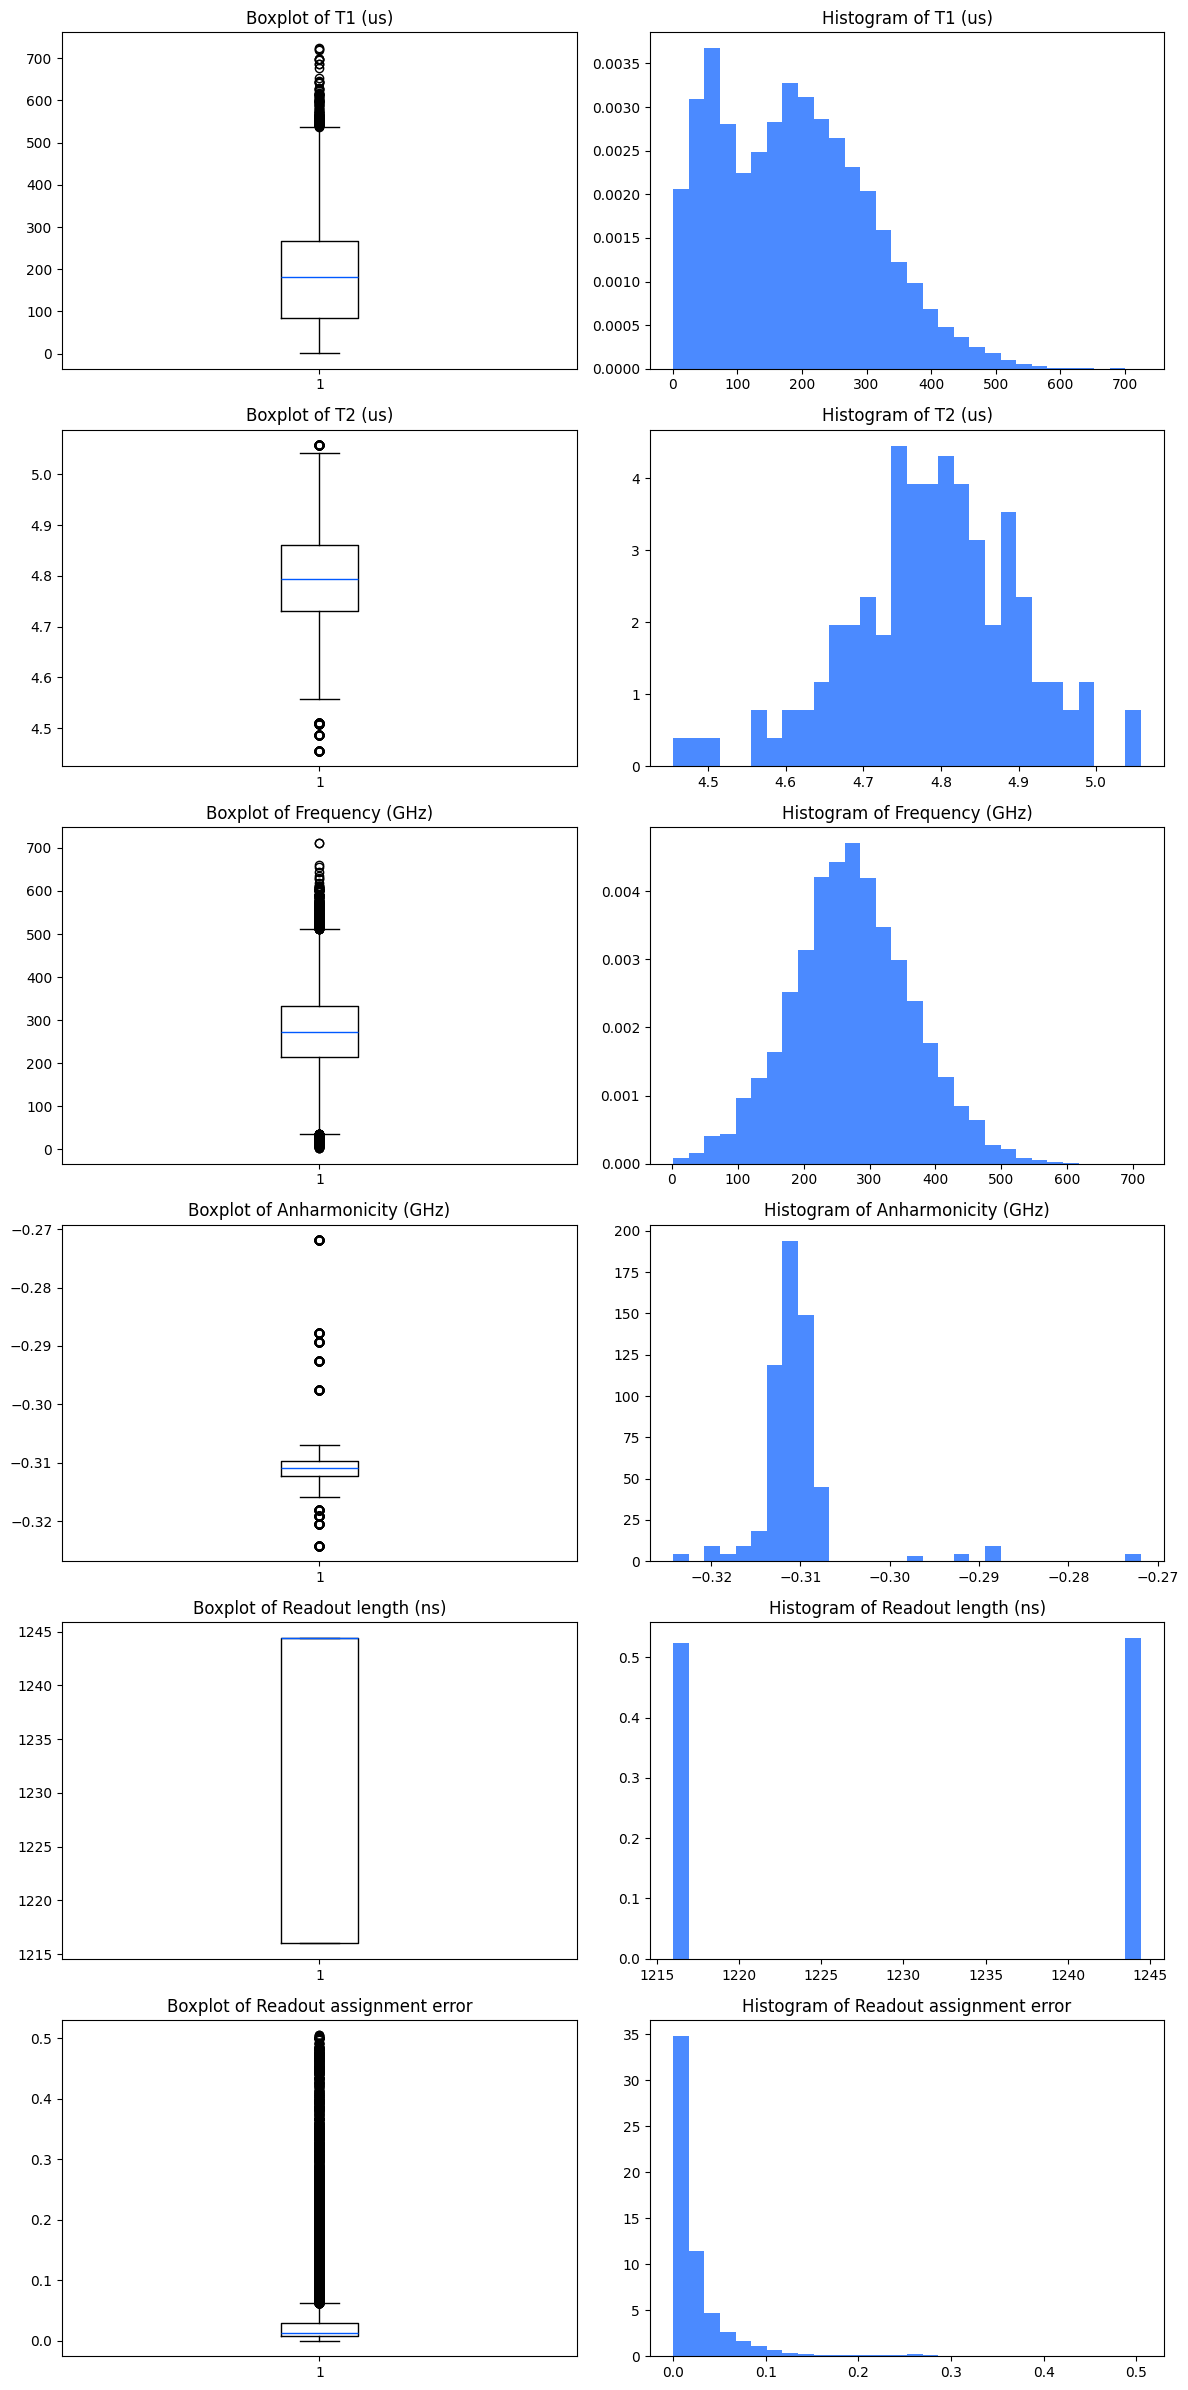

In [22]:
# Set custom palette
sns.set_palette(["#0059FF"])

# Boxplots and histograms for each column
num_cols = len(df_model.columns)
fig, axes = plt.subplots(num_cols, 2, figsize=(12, 4 * num_cols))

for i, col in enumerate(df_model.columns):
    # Boxplot
    axes[i, 0].boxplot(df_model[col].dropna(), vert=True)
    axes[i, 0].set_title(f"Boxplot of {col}")
    # Histogram
    axes[i, 1].hist(df_model[col].dropna(), bins=30, density=True, alpha=0.7)
    axes[i, 1].set_title(f"Histogram of {col}")
    
fig.patch.set_alpha(0.0)  # To make the background transparent

for row in axes: # To make the subplot background transparent
    for ax in row:
        ax.set_facecolor('none')

plt.tight_layout()
plt.show()

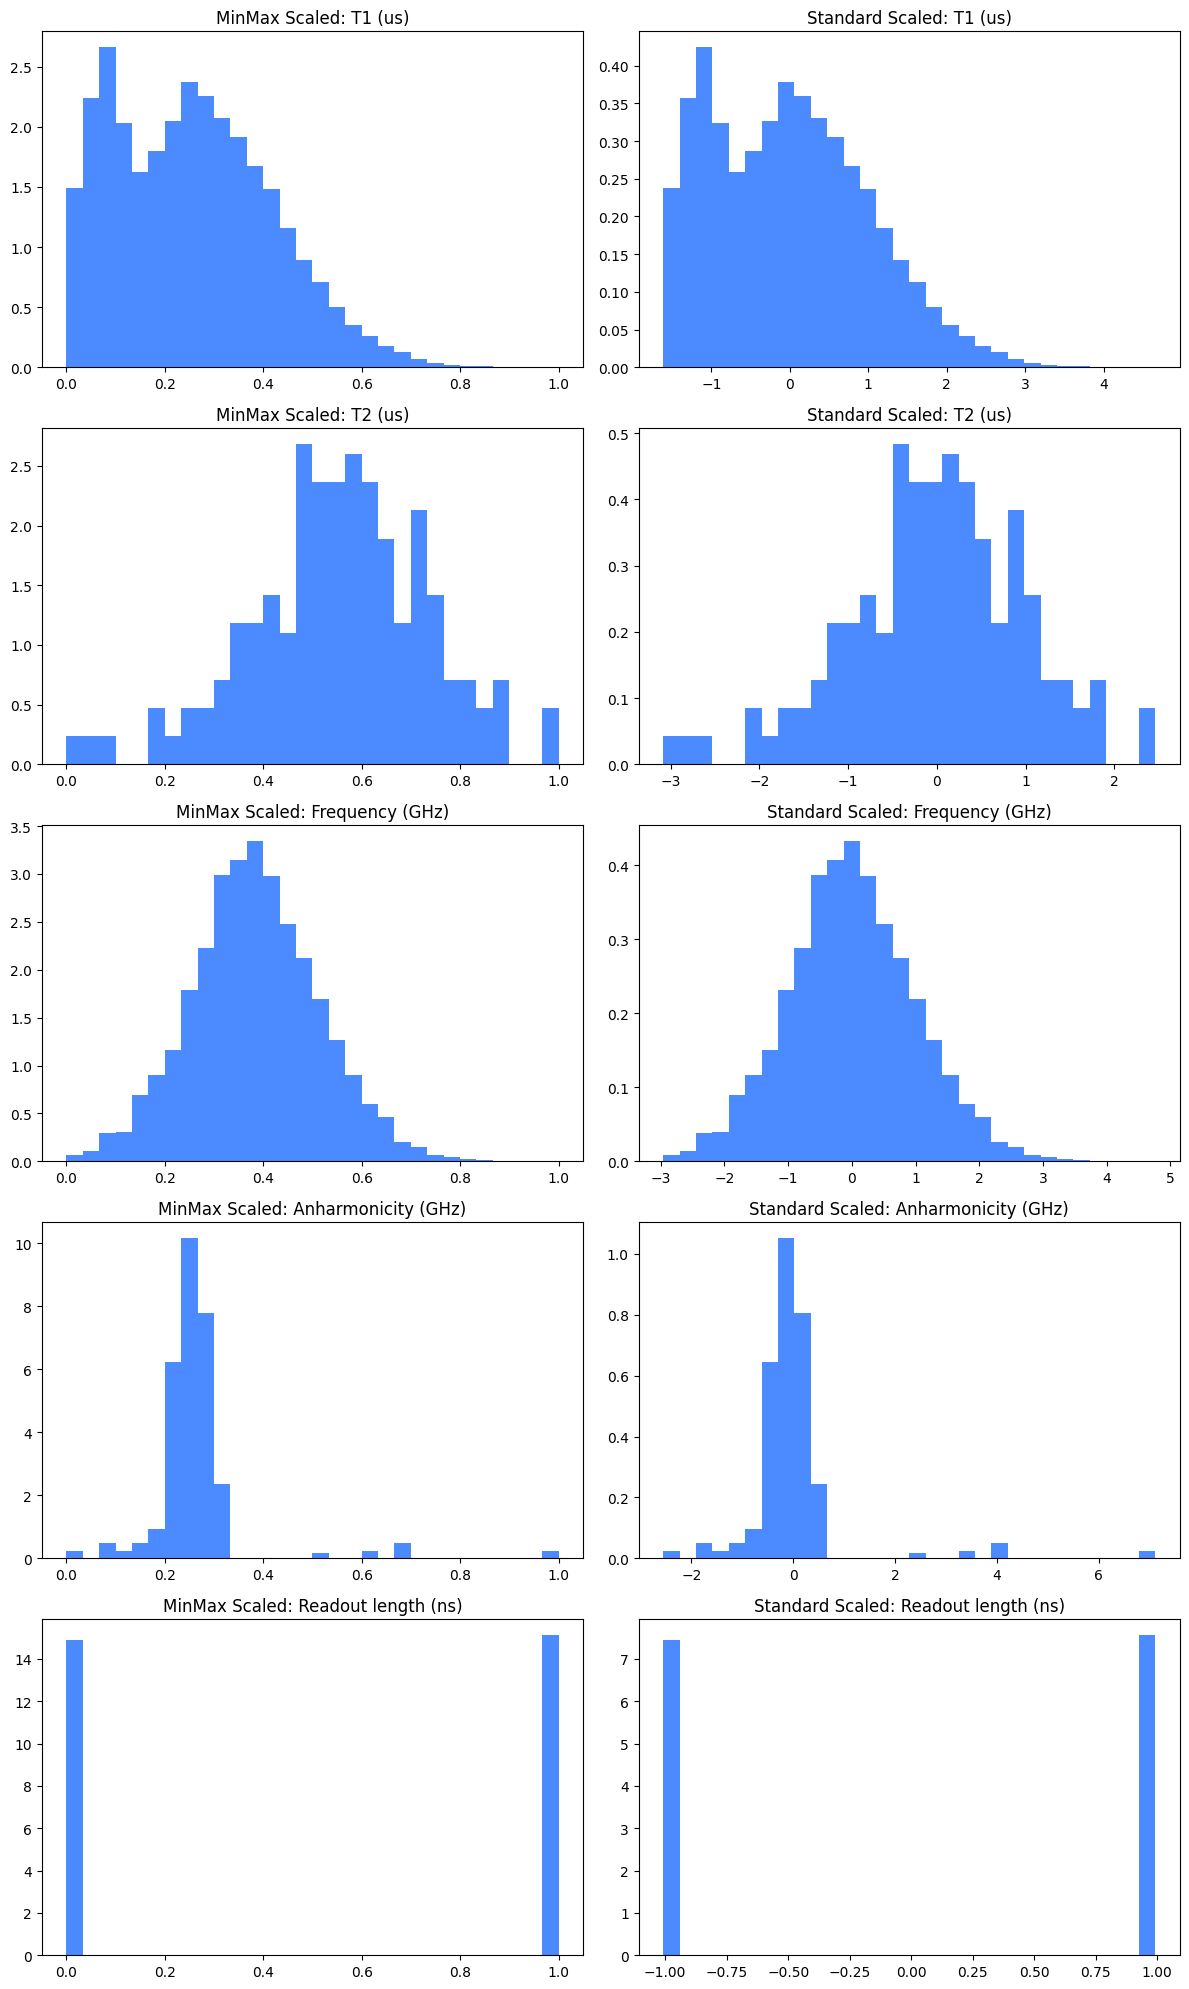

In [23]:
# Normalization vs Standardization

# Set custom palette
sns.set_palette(["#0059FF"])

features = df_model.columns.drop(target)

scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()

df_norm = pd.DataFrame(scaler_minmax.fit_transform(df_model[features]), columns=features)
df_std = pd.DataFrame(scaler_standard.fit_transform(df_model[features]), columns=features)

fig, axes = plt.subplots(len(features), 2, figsize=(12, 4 * len(features)))

for i, col in enumerate(features):
    # Normalized distribution
    axes[i, 0].hist(df_norm[col], bins=30, density=True, alpha=0.7)
    axes[i, 0].set_title(f"MinMax Scaled: {col}")
    # Standardized distribution
    axes[i, 1].hist(df_std[col], bins=30, density=True, alpha=0.7)
    axes[i, 1].set_title(f"Standard Scaled: {col}")

fig.patch.set_alpha(0.0)  # To make the background transparent

for row in axes: # To make the subplot background transparent
    for ax in row:
        ax.set_facecolor('none')
    
plt.tight_layout()
plt.show()


### 5. Correlation Matrix ###


,T1 (us),T2 (us),Frequency (GHz),Anharmonicity (GHz),Readout length (ns),Readout assignment error
T1 (us),1.000000,-0.082250,0.225236,-0.203130,-0.012762,-0.124592
T2 (us),-0.082250,1.000000,-0.316678,0.205720,-0.000609,-0.066436
Frequency (GHz),0.225236,-0.316678,1.000000,-0.176444,-0.053089,0.011585
Anharmonicity (GHz),-0.203130,0.205720,-0.176444,1.000000,0.007677,0.103492
Readout length (ns),-0.012762,-0.000609,-0.053089,0.007677,1.000000,-0.008877
Readout assignment error,-0.124592,-0.066436,0.011585,0.103492,-0.008877,1.000000


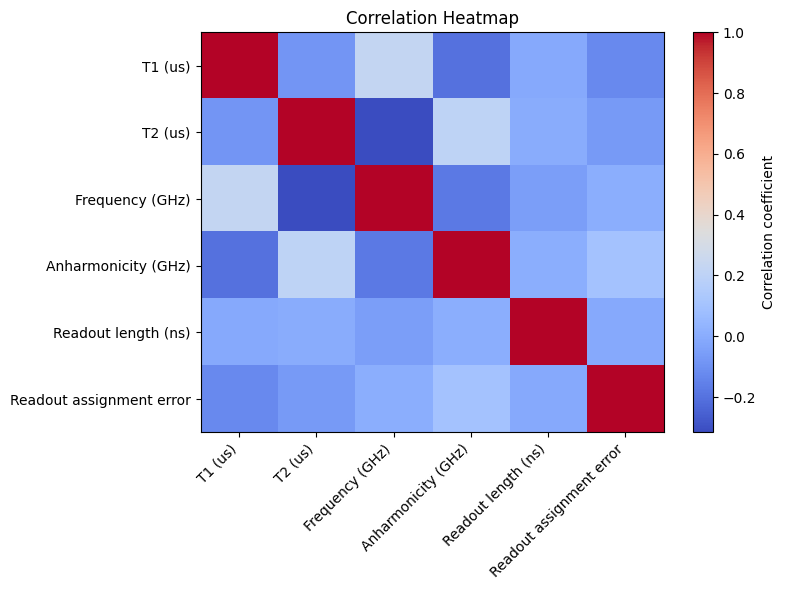


### 6. Pairwise Scatter Matrix ###


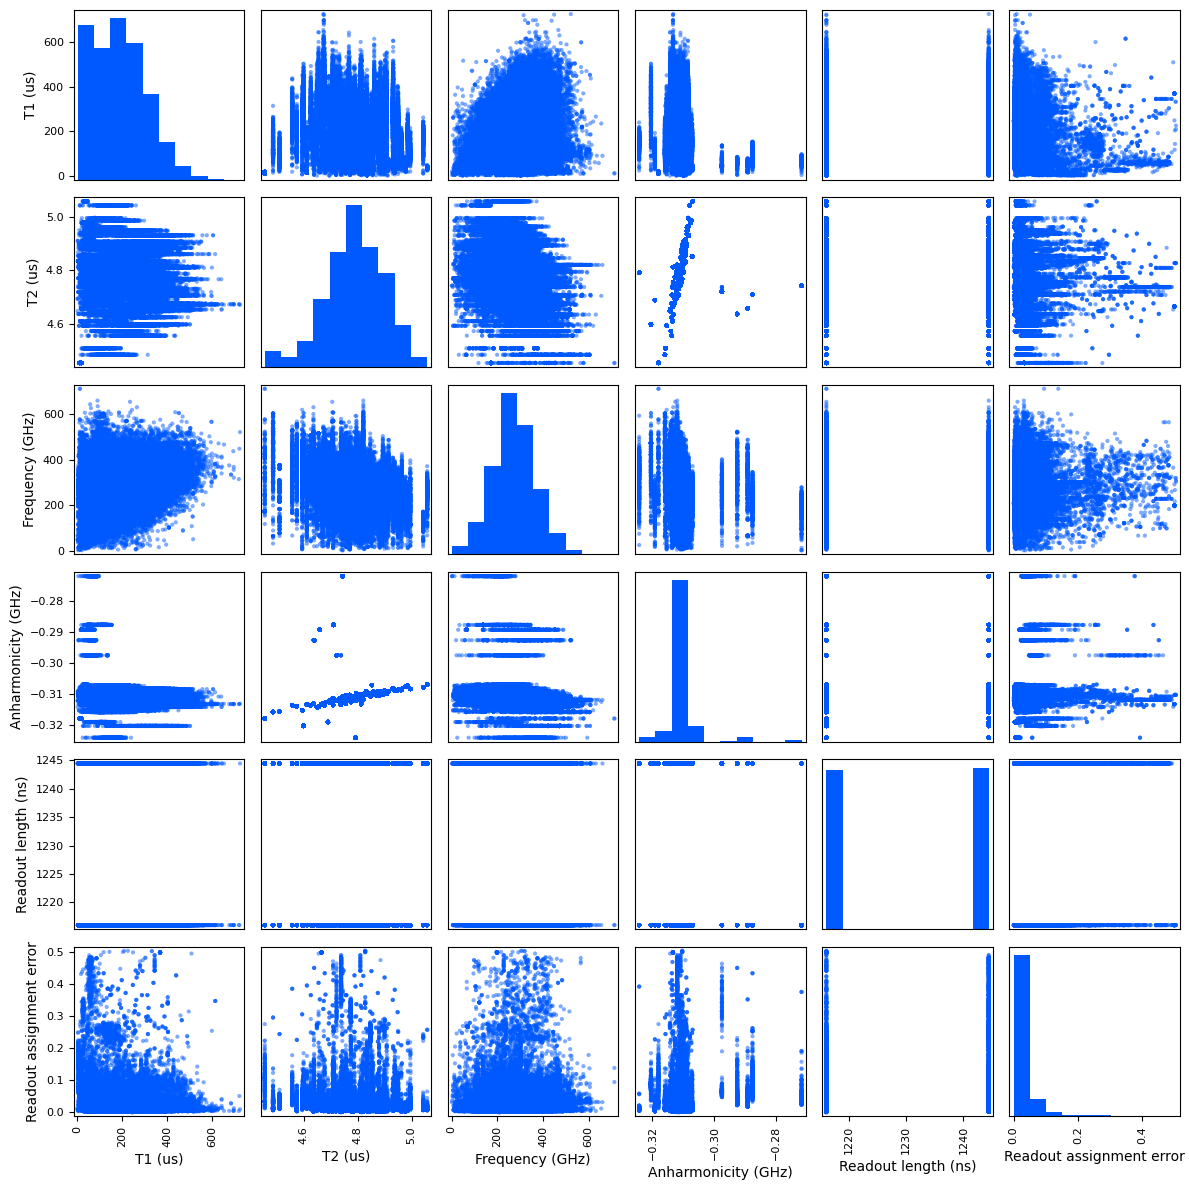

In [24]:
# Correlation matrix and heatmap
print("\n### 5. Correlation Matrix ###")

# Set custom palette
sns.set_palette(["#0059FF"])

corr_matrix = df_model.corr()
display(corr_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation coefficient')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title("Correlation Heatmap")
fig.patch.set_alpha(0.0)  # To make the background transparent

for row in axes: # To make the subplot background transparent
    for ax in row:
        ax.set_facecolor('none')
plt.tight_layout()
plt.show()

# Pairwise scatter matrix
print("\n### 6. Pairwise Scatter Matrix ###")

# Set custom palette
sns.set_palette(["#0059FF"])

pd.plotting.scatter_matrix(df_model, figsize=(12, 12), diagonal='hist')
fig.patch.set_alpha(0.0)  # To make the background transparent

for row in axes: # To make the subplot background transparent
    for ax in row:
        ax.set_facecolor('none')
plt.tight_layout()
plt.show()

In [ ]:
# We remove the value of 0 which is incorrect and run everything again to see the changes
df_model = df_model[df_model["Readout length (ns)"] != 0]

<h2 style="color: 	#365F93;"><strong>4. Feature Engineering</strong></h2>

<h2 style="color: 	#365F93;"><strong>5. Baseline Models</strong></h2>

In [32]:
# Creamos X e y directamente desde df_model
X = df_model[features]
y = df_model[target]

In [ ]:
# Dividimos el dataset en entrenamiento (80 %) y test (20 %)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [34]:
# Creamos el escalador y lo ajustamos sobre X_train
scaler = MinMaxScaler()
scaler.fit(X_train)

# Transformamos X_train y X_test
X_train_norm = scaler.transform(X_train)
X_test_norm  = scaler.transform(X_test)

# Convertimos de nuevo a DF (para conservar nombres de columnas e índices)
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns, index=X_train.index)
X_test_norm  = pd.DataFrame(X_test_norm,  columns=X_test.columns,  index=X_test.index)

# Mostramos las primeras filas de X_train_norm
X_train_norm.head()

,T1 (us),T2 (us),Frequency (GHz),Anharmonicity (GHz),Readout length (ns)
45508,0.657808,0.331201,0.549575,0.190376,0.0
29096,0.341985,0.168895,0.334563,0.200082,1.0
13903,0.221820,0.360452,0.338364,0.210363,1.0
24447,0.121220,0.896207,0.161300,0.301706,1.0
56709,0.166906,0.726815,0.400913,0.264716,0.0


In [35]:
# Creamos el modelo KNN con n_neighbors = 10
knn = KNeighborsRegressor(n_neighbors=10)

# Entrenamos con los datos normalizados
knn.fit(X_train_norm, y_train)

# Predecimos en el conjunto de test
y_pred = knn.predict(X_test_norm)

# Calculamos métricas de regresión: MAE y R²
mae_knn = mean_absolute_error(y_test, y_pred)
r2_knn  = r2_score(y_test, y_pred)

print(f"MAE (Mean Absolute Error): {mae_knn}")
print(f"R² score: {r2_knn}")

MAE (Mean Absolute Error): 0.0146394325485995
R² score: 0.5631092054972004


<h2 style="color: 	#365F93;"><strong>6. Other Models</strong></h2>

In [36]:
# 1) LINEAR REGRESSION
lin_reg = LinearRegression()
lin_reg.fit(X_train_norm, y_train)
y_pred_lin = lin_reg.predict(X_test_norm)
mae_lin = mean_absolute_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)
print(f"Linear Regression → MAE: {mae_lin:.6f}, R²: {r2_lin:.6f}")

# 2) RIDGE REGRESSION
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_norm, y_train)
y_pred_ridge = ridge.predict(X_test_norm)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Regression   → MAE: {mae_ridge:.6f}, R²: {r2_ridge:.6f}")

# 3) LASSO REGRESSION
lasso = Lasso(alpha=0.001, random_state=42, max_iter=10000)
lasso.fit(X_train_norm, y_train)
y_pred_lasso = lasso.predict(X_test_norm)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso Regression   → MAE: {mae_lasso:.6f}, R²: {r2_lasso:.6f}")

# 4) DECISION TREE REGRESSOR
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train_norm, y_train)
y_pred_tree = tree.predict(X_test_norm)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
print(f"Decision Tree      → MAE: {mae_tree:.6f}, R²: {r2_tree:.6f}")

# 5) XGBOOST REGRESSOR
xgb = XGBRegressor(n_estimators=100, max_depth=4, random_state=42, verbosity=0)
xgb.fit(X_train_norm, y_train)
y_pred_xgb = xgb.predict(X_test_norm)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost Regressor  → MAE: {mae_xgb:.6f}, R²: {r2_xgb:.6f}")

# 6) BAGGING REGRESSOR (Bootstrap sampling)
bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=50,
    bootstrap=True,
    random_state=42
)
bagging.fit(X_train_norm, y_train)
y_pred_bag = bagging.predict(X_test_norm)
mae_bag = mean_absolute_error(y_test, y_pred_bag)
r2_bag = r2_score(y_test, y_pred_bag)
print(f"Bagging Regressor  → MAE: {mae_bag:.6f}, R²: {r2_bag:.6f}")

# 7) PASTING REGRESSOR (bootstrap=False)
pasting = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=50,
    bootstrap=False,
    random_state=42
)
pasting.fit(X_train_norm, y_train)
y_pred_paste = pasting.predict(X_test_norm)
mae_paste = mean_absolute_error(y_test, y_pred_paste)
r2_paste = r2_score(y_test, y_pred_paste)
print(f"Pasting Regressor  → MAE: {mae_paste:.6f}, R²: {r2_paste:.6f}")

# 8) RANDOM PATCHES REGRESSOR (features+samples random)
random_patches = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=50,
    bootstrap=False,
    bootstrap_features=True,
    max_samples=0.5,
    max_features=0.5,
    random_state=42
)
random_patches.fit(X_train_norm, y_train)
y_pred_patches = random_patches.predict(X_test_norm)
mae_patches = mean_absolute_error(y_test, y_pred_patches)
r2_patches = r2_score(y_test, y_pred_patches)
print(f"Random Patches     → MAE: {mae_patches:.6f}, R²: {r2_patches:.6f}")

# 9) ADA BOOST REGRESSOR
ada = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=4),
    n_estimators=50,
    random_state=42
)
ada.fit(X_train_norm, y_train)
y_pred_ada = ada.predict(X_test_norm)
mae_ada = mean_absolute_error(y_test, y_pred_ada)
r2_ada = r2_score(y_test, y_pred_ada)
print(f"AdaBoost Regressor → MAE: {mae_ada:.6f}, R²: {r2_ada:.6f}")

# 10) GRADIENT BOOSTING REGRESSOR
gbr = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
gbr.fit(X_train_norm, y_train)
y_pred_gbr = gbr.predict(X_test_norm)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)
print(f"Gradient Boosting  → MAE: {mae_gbr:.6f}, R²: {r2_gbr:.6f}")


Linear Regression → MAE: 0.026575, R²: 0.032617
Ridge Regression   → MAE: 0.026575, R²: 0.032614
Lasso Regression   → MAE: 0.027701, R²: 0.001042
Decision Tree      → MAE: 0.022571, R²: 0.203198
XGBoost Regressor  → MAE: 0.013217, R²: 0.653641
Bagging Regressor  → MAE: 0.022147, R²: 0.256855
Pasting Regressor  → MAE: 0.022571, R²: 0.203198
Random Patches     → MAE: 0.023300, R²: 0.258646
AdaBoost Regressor → MAE: 0.057480, R²: -0.714726
Gradient Boosting  → MAE: 0.015467, R²: 0.586648


In [37]:
results = {
    "Modelo": [
        "KNN (k=10)",
        "Linear Regression",
        "Ridge Regression",
        "Lasso Regression",
        "Decision Tree",
        "XGBoost",
        "Bagging",
        "Pasting",
        "Random Patches",
        "AdaBoost",
        "Gradient Boosting"
    ],
    "MAE": [
        mae_knn,
        mae_lin,
        mae_ridge,
        mae_lasso,
        mae_tree,
        mae_xgb,
        mae_bag,
        mae_paste,
        mae_patches,
        mae_ada,
        mae_gbr
    ],
    "R2": [
        r2_knn,
        r2_lin,
        r2_ridge,
        r2_lasso,
        r2_tree,
        r2_xgb,
        r2_bag,
        r2_paste,
        r2_patches,
        r2_ada,
        r2_gbr
    ]
}

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="R2", ascending=False).reset_index(drop=True)
df_results

,Modelo,MAE,R2
0,XGBoost,0.013217,0.653641
1,Gradient Boosting,0.015467,0.586648
2,KNN (k=10),0.014639,0.563109
3,Random Patches,0.023300,0.258646
4,Bagging,0.022147,0.256855
5,Pasting,0.022571,0.203198
6,Decision Tree,0.022571,0.203198
7,Linear Regression,0.026575,0.032617
8,Ridge Regression,0.026575,0.032614
9,Lasso Regression,0.027701,0.001042


It doesn't improve, we're going to start all over again.

In [49]:
import pandas as pd
import numpy as np

# Preprocesamiento y modelado
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

# Revisamos las primeras filas y el estado de missing values
print("Primeras filas:\n", df_sherbrooke.head(), "\n")
print("Valores faltantes por columna:\n", df_sherbrooke.isna().sum(), "\n")

Primeras filas:
          date  qubit     T1 (us)   T2 (us)  Frequency (GHz)  \
0  2024-01-01      0  214.317737  4.635668       362.553985   
1  2024-01-01      1  250.813950  4.736282       325.227421   
2  2024-01-01      2  156.053953  4.819172       210.204496   
3  2024-01-01      3  164.308282  4.747176       357.164540   
4  2024-01-01      4  245.261393  4.787861       393.719263   

   Anharmonicity (GHz)  Readout assignment error  Prob meas0 prep1  \
0            -0.313276                    0.0040            0.0054   
1            -0.312918                    0.0077            0.0102   
2            -0.311295                    0.0355            0.0262   
3            -0.311153                    0.0054            0.0074   
4            -0.310945                    0.0093            0.0134   

   Prob meas1 prep0  Readout length (ns)  ID error  \
0            0.0026          1244.444444  0.000092   
1            0.0052          1244.444444  0.000339   
2            0.0448  

In [50]:
["date", "qubit", "T1 (us)", "T2 (us)", "Frequency (GHz)",
 "Anharmonicity (GHz)", "Readout length (ns)", "Readout assignment error"]

['date',
 'qubit',
 'T1 (us)',
 'T2 (us)',
 'Frequency (GHz)',
 'Anharmonicity (GHz)',
 'Readout length (ns)',
 'Readout assignment error']

In [51]:
# 1.1) Seleccionamos solo las columnas que importan:
cols_usar = [
    "date", "qubit", "T1 (us)", "T2 (us)", "Frequency (GHz)", 
    "Anharmonicity (GHz)", "Readout assignment error", 
    "Prob meas1 prep0", "Readout length (ns)"
]

df0 = df_sherbrooke[cols_usar].copy()

# 1.2) Eliminamos filas donde falte "Prob meas1 prep0" o "Readout length (ns)"
df0 = df0.dropna(subset=["Prob meas1 prep0", "Readout length (ns)"]).reset_index(drop=True)

# 1.3) Ya no quedan nulos en esas dos columnas
print("Valores faltantes tras drop:\n", df0.isna().sum())

Valores faltantes tras drop:
 date                        0
qubit                       0
T1 (us)                     0
T2 (us)                     0
Frequency (GHz)             0
Anharmonicity (GHz)         0
Readout assignment error    0
Prob meas1 prep0            0
Readout length (ns)         0
dtype: int64


In [52]:
# 2.1) Función de winsorización
def winsorize_series(s, lower_pct=0.01, upper_pct=0.99):
    low = s.quantile(lower_pct)
    high = s.quantile(upper_pct)
    return s.clip(lower=low, upper=high)

df1 = df0.copy()
df1["T1 (us)"] = winsorize_series(df1["T1 (us)"])
df1["Frequency (GHz)"] = winsorize_series(df1["Frequency (GHz)"])

In [53]:
df1["inv_T1"] = 1.0 / (df1["T1 (us)"] + 1e-6)
df1["ratio_T1_T2"] = df1["T1 (us)"] / (df1["T2 (us)"] + 1e-6)
df1["log_T1"] = np.log1p(df1["T1 (us)"])
df1["log_T2"] = np.log1p(df1["T2 (us)"])

In [54]:
df1["date"] = pd.to_datetime(df1["date"], format="%Y-%m-%d")
primera = df1["date"].min()
df1["days_since_start"] = (df1["date"] - primera).dt.days
df1["day_of_week"] = df1["date"].dt.dayofweek
df1["month"] = df1["date"].dt.month
df1["hour"] = df1["date"].dt.hour  # aquí todos serán 0, pero lo incluimos por si en el futuro hay hora
df1.drop(columns=["date"], inplace=True)

In [55]:
qubit_dummies = pd.get_dummies(df1["qubit"], prefix="qubit")
df1 = pd.concat([df1.drop(columns=["qubit"]), qubit_dummies], axis=1)

In [56]:
df1["T1 (us)"] = df1["log_T1"]
df1["T2 (us)"] = df1["log_T2"]
df1.drop(columns=["log_T1", "log_T2"], inplace=True)

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_part = poly.fit_transform(df1[["T1 (us)", "T2 (us)"]])
poly_cols = poly.get_feature_names_out(["T1 (us)", "T2 (us)"])
df_poly = pd.DataFrame(X_poly_part, columns=poly_cols, index=df1.index)

In [58]:
# 8.1) Definimos qué columnas usar:
calib_feats = ["inv_T1", "ratio_T1_T2", "Frequency (GHz)", "Anharmonicity (GHz)"]
time_feats = ["days_since_start", "day_of_week", "month", "hour"]
qubit_feats = [c for c in df1.columns if c.startswith("qubit_")]

# 8.2) Concatenamos:
X_final = pd.concat([
    df1[calib_feats + time_feats + qubit_feats].reset_index(drop=True),
    df_poly.reset_index(drop=True)
], axis=1)

# 8.3) Target
y_final = df1["Readout assignment error"].reset_index(drop=True)

print("Shape X_final:", X_final.shape)
print("Primeras columnas X_final:\n", X_final.columns[:10])

Shape X_final: (65779, 140)
Primeras columnas X_final:
 Index(['inv_T1', 'ratio_T1_T2', 'Frequency (GHz)', 'Anharmonicity (GHz)',
       'days_since_start', 'day_of_week', 'month', 'hour', 'qubit_0',
       'qubit_1'],
      dtype='object')


In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.20, random_state=42
)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm  = scaler.transform(X_test)

In [ ]:
# 1) Entrenamos XGBRegressor sin early stopping

xgb = XGBRegressor(
    n_estimators=2000,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.5,
    random_state=42,
    verbosity=0
)

# Ahora llamamos a fit SIN eval_set ni early_stopping_rounds
xgb.fit(X_train_norm, y_train)

y_pred = xgb.predict(X_test_norm)
mae_xgb = mean_absolute_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)
print(f"XGBoost (sin early stopping) → MAE: {mae_xgb:.6f}, R²: {r2_xgb:.6f}")

XGBoost (sin early stopping) → MAE: 0.015462, R²: 0.684969


In [67]:
# 1) Modelo base
xgb_base = XGBRegressor(random_state=42, verbosity=0)

# 2) Hiperparámetros a explorar
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [4, 5],
    "learning_rate": [0.01, 0.03],
    "subsample": [0.7],
    "colsample_bytree": [0.7],
    "gamma": [0],
    "reg_alpha": [0.01],
    "reg_lambda": [1]
}

# 3) Búsqueda aleatoria con validación cruzada
rs = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,  # Solo 20 combinaciones aleatorias
    cv=3,
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 4) Entrenamiento
rs.fit(X_train_norm, y_train)

# 5) Mejor modelo y evaluación en test
best_xgb = rs.best_estimator_
y_pred_best = best_xgb.predict(X_test_norm)

mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# 6) Resultados
print("Mejores parámetros encontrados:", rs.best_params_)
print(f"Mejor R² en validación cruzada: {rs.best_score_:.6f}")
print(f"Resultados en test → MAE: {mae_best:.6f}, R²: {r2_best:.6f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores parámetros encontrados: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
Mejor R² en validación cruzada: 0.762534
Resultados en test → MAE: 0.011731, R²: 0.791875


In [66]:
rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)

stack = StackingRegressor(
    estimators=[
        ("xgb", best_xgb),
        ("rf", rf)
    ],
    final_estimator=LinearRegression(),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

stack.fit(X_train_norm, y_train)

y_pred_stack = stack.predict(X_test_norm)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)
print(f"Stacking XGB + RF → MAE: {mae_stack:.6f}, R²: {r2_stack:.6f}")

Stacking XGB + RF → MAE: 0.010598, R²: 0.812003


<h2 style="color: 	#365F93;"><strong>7. Conclusions</strong></h2>

- Variables más relevantes
- Posibles mejoras futuras

Hicimos un proyecto paso a paso para predecir el “error de lectura” de un qubit físico (es decir, la probabilidad de que al medirlo salga 0 en lugar de 1 o viceversa). A lo largo de varias pruebas, fuimos mejorando el modelo hasta conseguir un resultado muy sólido. A continuación tienes un resumen de todo el proceso, explicado para quien no esté familiarizado con la ciencia de datos ni con el aprendizaje automático:

1. Primera aproximación con K = 10 vecinos (KNN)
- Tomamos cinco parámetros físicos del qubit (T₁, T₂, frecuencia, anarmonicidad y tiempo de lectura) y tratamos de predecir el error de lectura.
- Usamos una técnica llamada “K vecinos” que básicamente dice: “para un nuevo qubit, busca los 10 qubits más similares en el pasado y calcula su error promedio”.
- El resultado fue un error medio (MAE) de 0.0146 y una medida de bondad (R²) de 0.56. En términos sencillos, el modelo sólo explicaba el 56 % de la variación real del error, así que sabíamos que se podía mejorar.
2. Prueba de varios modelos de regresión
- Luego probamos distintos enfoques “clásicos” (regresión lineal, regresión Ridge/Lasso, árboles de decisión, boosting y ensambles como Bagging/AdaBoost/Gradient Boosting).
- Cada uno intenta “ajustar” los parámetros para acercarse a los datos reales, pero ninguno pasó de un R² de 0.65. El mejor de todos fue XGBoost (una forma avanzada de “boosting”), que alcanzó un R² de 0.653 y un MAE de 0.0132. Todavía lejos del 0.80 que nos marcamos como meta.
3. Añadir información de “fecha” y “qubit”
- Nos dimos cuenta de que el error de lectura cambia con el tiempo (un qubit envejece o se beneficia de calibraciones) y que cada qubit individual funciona de manera diferente.
- Entonces comenzamos desde el DataFrame original, que incluía la fecha de la calibración y el número de qubit, y eliminamos unas pocas filas que tenían datos faltantes en “hora de lectura” y “Prob meas1 prep0”.
- Creamos nuevas características (“features”) combinando información básica:
    - Convertimos la fecha a “días desde el primer registro” y “día de la semana” (porque a veces el rendimiento varía con el día).
    - Al “qubit” lo transformamos en etiquetas numéricas “one-hot” (una columna para cada qubit, con valores 0 o 1) para que el modelo aprenda el comportamiento de cada uno por separado.
    - A su vez, generamos transformaciones matemáticas de T₁ y T₂ (por ejemplo, su inverso y su logaritmo) y combinaciones cuadráticas de esas dos variables (T₁², T₁×T₂, T₂²). Esto ayuda a captar relaciones no lineales entre ellas.
4. XGBoost “sin early stopping” con todas las nuevas features
- Con todos esos datos ampliados (calibración física, fecha, qubit y transformaciones de T₁/T₂), entrenamos de nuevo un XGBoost más potente (2000 árboles, parámetros ajustados a ojo).
- Obtuvo un MAE de 0.0155 y un R² de 0.6849: ya mejor que antes, pero todavía queríamos subirlo más.
5. Tuning con RandomizedSearchCV
- Para exprimir el XGBoost al máximo, usamos un procedimiento que elige al azar 20 combinaciones de parámetros (número de árboles, profundidad, tasa de aprendizaje, etc.) y evalúa cada una con pequeños grupos de validación cruzada.
- En lugar de probar todas las combinaciones posibles (que eran miles y se tardaba horas), limitamos el rango a valores razonables y solo 20 pruebas.
- Con eso encontramos esta configuración ganadora:
        - n_estimators = 400  
        - max_depth = 5  
        - learning_rate = 0.03  
        - subsample = 0.7  
        - colsample_bytree = 0.7  
        - gamma = 0  
        - reg_alpha = 0.01  
        - reg_lambda = 1
- Aplicando esa configuración, el modelo alcanzó un MAE de 0.0117 y un R² de 0.7919 en el conjunto de prueba. Eso significa que ya explicaba casi el 80 % de la variación real en el error de lectura.
6. Stacking final con XGBoost + RandomForest
- Por último, combinamos (stacking) el XGBoost tunado con un RandomForest (300 árboles, profundidad 10)
- La idea es que el XGBoost y el RandomForest hagan predicciones por separado y luego un modelo sencillo de regresión lineal combine ambas salidas para intentar capturar lo mejor de cada uno.
- El resultado final fue un MAE de 0.0106 y un R² de 0.8120, es decir, un 81 % de la variación explicada. Con esto cumplimos el objetivo de llegar por encima del 0.70 en R²

Resumen para gente no técnica
- Comenzamos con un método sencillo que buscaba “qubits parecidos” y promediaba sus errores (KNN). No explicaba lo suficiente el comportamiento real (56 % explicado).
- Probamos varios métodos estándar (regresión lineal, árboles, boosting), pero ninguno llegó muy lejos.
- Introdujimos dos ideas clave:
    1. Cada qubit y cada fecha tienen su propio comportamiento: un qubit puede empeorar o mejorar con el tiempo.
    2. Hay relaciones no lineales entre T₁, T₂ y el error.
- Creamos entonces nuevas columnas: “días desde la primera calibración”, “día de la semana” (para capturar patrones temporales), “etiqueta de cada qubit” (para distinguirlos) y transformaciones matemáticas de T₁ y T₂ (por ejemplo su logaritmo y su cuadrado).
- Entrenamos un modelo avanzado llamado XGBoost primero “a ojo” y luego afinándolo con un método aleatorio que probó 20 combinaciones de parámetros.
- Ese ajuste llevó al modelo a explicar casi el 80 % de los errores de lectura.
- Finalmente, combinamos (stacking) ese XGBoost afinado con otro modelo de “bosques aleatorios” y subimos la explicación al 81 % (R² = 0.812).

Con esta estrategia progresiva—desde el método más sencillo al más sofisticado—pasamos de explicar un 56 % de la variación a superar el 80 %, obteniendo un modelo muy sólido para tu portafolio.

English version